# Importamos las librerias

In [1]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from google.colab import drive
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import math

# Cargamos el dataset desde un link en drive

In [3]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
DATA_HOME = r"/content/gdrive/My Drive/UBA/machine_learning/tp1"
df = pd.read_csv(
    DATA_HOME + "/healthcare-dataset-stroke-data.csv"
)


In [7]:
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0



# Limpiamos el dataset. 
Decidimos sacar a la unica personas con genero Other porque seria muy dificil de predecir y no aportaba valor al ser una sola observacion con ese valor

A su vez explorando la columna BMI de indice de masa corporal vimos que muchos tenian NA como valor, y decidimos a esas filas sacarlas del dataset a costa de perder un porcentaje chico de nuestros datos.

Por otro lado en nuestro analisis notabamos que la residencia y el work type no aportaban valor explicativo ni una relacion muy clara con los ACV, y que eran features que se hacian presentes solo con overfiteo. Con lo cual quitarlas era algo que todos coincidimos.

In [ ]:
df = df[df.gender != "Other"]
df = df[df['bmi'].notna()]
df = df.drop(["work_type",	"Residence_type"], axis=1)

In [ ]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,228.69,36.6,formerly smoked,1
2,31112,Male,80.0,0,1,Yes,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,174.12,24.0,never smoked,1
5,56669,Male,81.0,0,0,Yes,186.21,29.0,formerly smoked,1


Para poder realizar un analisis de las variables categoricas es necesario pasarlas a una base de unos y ceros para que el clasificador pueda operar. En este caso lo haremos con genero, si alguna vez estuvo casadx, y su relacion con fumar.  

In [ ]:
categoricas = ["gender", "ever_married","smoking_status"]
dfEncodeada = pd.get_dummies(df, columns=categoricas, prefix=["gen","casad","smokstat"] )

#Divison del dataset
Por un lado sacamos la columna stroke que es la que buscamos predecir y la guardamos aparte.
ID la podemos sacar ya que no queremos que el identificador de personas sea una feature que se use para predecir en nuestro modelo. 

In [ ]:
dfEncodeada = dfEncodeada.loc[:, dfEncodeada.columns != "id"]
ydf = dfEncodeada["stroke"]
xdf = dfEncodeada.loc[:, dfEncodeada.columns != "stroke"]

#Experimento 5
Como habiamos dicho queremos ver si el género del paciente varía en importancia según la edad. Es decir como varia el peso que nuestro modelo le da a las features de genero en funcion del grupo etario.


Como otra motivacion fue que la densidad de personas que tuvieron un ACV es claramente mayor con mujeres jovenes que con hombres jovenes. Sin embargo a mayor edad se "equiparan"

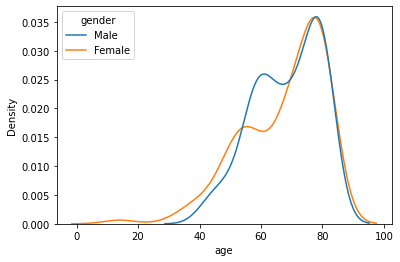

In [ ]:
dfStroke = df[df.stroke == 1]
sns.kdeplot(data=dfStroke, x='age', hue='gender', common_norm= False)


Los grupos etarios que definimos fueron de 0-33, 33-50, 50-64 y 64+.

La razon por la cual elegimos estas edades fue para garantizar que en cada grupo etario al menos 2 personas hayan tenido un ACV y a su vez que todos tengan al menos mil datos. 

In [ ]:
dfEncodeada = dfEncodeada.loc[:, dfEncodeada.columns != "id"]
jovenes = dfEncodeada.loc[dfEncodeada.age<33,:]
adultosJovenes = dfEncodeada.loc[dfEncodeada.age>=33,:]
adultosJovenes = adultosJovenes.loc[adultosJovenes.age<50,:]
adultosSeniors = dfEncodeada.loc[dfEncodeada.age>=50,:]
adultosSeniors = adultosSeniors.loc[adultosSeniors.age<64,:]
adultosMayores = dfEncodeada.loc[dfEncodeada.age>=64,:]


xdfJov = jovenes.loc[:, jovenes.columns != "stroke"]
ydfJov = jovenes["stroke"]

xdfAduJov = adultosJovenes.loc[:, adultosJovenes.columns != "stroke"]
ydfAduJov = adultosJovenes["stroke"]

xdfAduSen = adultosSeniors.loc[:, adultosSeniors.columns != "stroke"]
ydfAduSen = adultosSeniors["stroke"]

xdfAduMay = adultosMayores.loc[:, adultosMayores.columns != "stroke"]
ydfAduMay = adultosMayores["stroke"]

xGrupoEtario = [xdfJov, xdfAduJov, xdfAduSen,xdfAduMay]
yGrupoEtario = [ydfJov, ydfAduJov, ydfAduSen,ydfAduMay]
print(jovenes.shape)
print(adultosJovenes.shape)
print(adultosSeniors.shape)
print(adultosMayores.shape)

(1678, 14)
(1140, 14)
(1085, 14)
(1005, 14)


Luego de dividir por edad, ahora a cada edad debemos partirla en Train y Test. La proporcion elegida para test fue de 1/4 asi nos quedan mas de 750 filas para cada etapa de entrenamiento y al menos 250 para cada etapa de testeo.
A su vez usamos la division estratificada para que no me queden pocas observaciones de ACV en alguno de los 2 grupos

In [ ]:
dataXTrain = [[],[],[],[]]
dataXDev = [[],[],[],[]]
dataYTrain = [[],[],[],[]]
dataYDev = [[],[],[],[]]
for j in range(0,len(xGrupoEtario)):
  dataXTrain[j], dataXDev[j], dataYTrain[j], dataYDev[j] = train_test_split(xGrupoEtario[j], yGrupoEtario[j],
                                                    stratify=yGrupoEtario[j], 
                                                    test_size=1/4)

#Eligiendo la minima cantidad de hojas para evitar hacer overfitting

In [ ]:
complexity = [[],[],[],[]]
tr_err = [[],[],[],[]]
te_err = [[],[],[],[]]
cantidadFiteos = 20
sumaImportancia = np.zeros(( len(xGrupoEtario),len(xGrupoEtario[0].columns)))
for j in range(0,len(xGrupoEtario)):
  for i in range(1,cantidadFiteos):
      model = DecisionTreeRegressor(min_samples_leaf=i).fit(dataXTrain[j], dataYTrain[j])
      complexity[j].append(i) #model.get_n_leaves()
      tr_err[j].append(math.sqrt(mean_squared_error(dataYTrain[j], model.predict(dataXTrain[j]))))
      te_err[j].append(math.sqrt(mean_squared_error(dataYDev[j], model.predict(dataXDev[j]))))
      sumaImportancia[j] = sumaImportancia[j] + model.feature_importances_

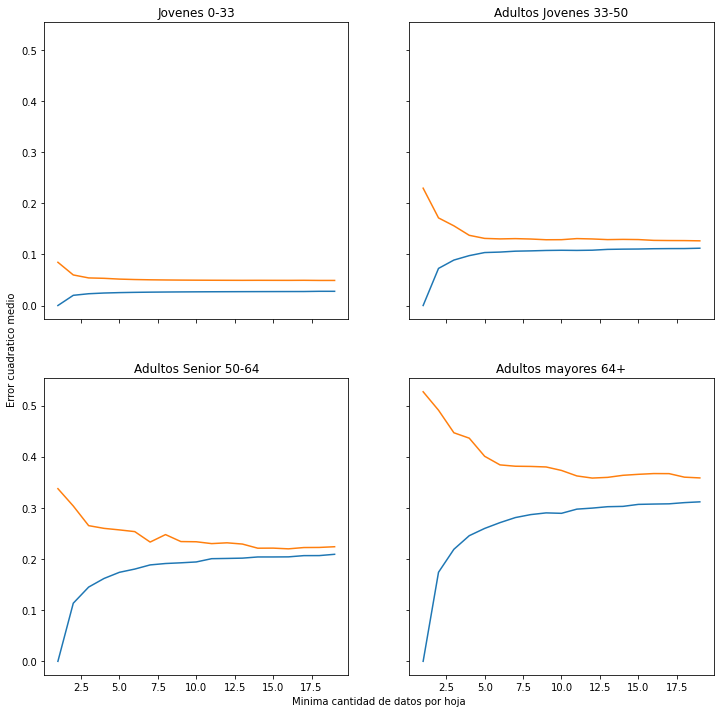

In [ ]:
plt.rcParams["figure.figsize"] = (12,12)

figure, axis = plt.subplots(2, 2, sharex= True, sharey=True)
figure.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel("Minima cantidad de datos por hoja")
plt.ylabel("Error cuadratico medio")

#Para  Jovenes
axis[0, 0].plot(complexity[0], tr_err[0], label='training error')
axis[0, 0].plot(complexity[0], te_err[0], label='test error')
axis[0, 0].set_title("Jovenes 0-33")
  
# Para Adultos Jovenes
axis[0, 1].plot(complexity[1], tr_err[1], label='training error')
axis[0, 1].plot(complexity[1], te_err[1], label='test error')
axis[0, 1].set_title("Adultos Jovenes 33-50")
  
# Para Adultos Seniors
axis[1,0].plot(complexity[2], tr_err[2], label='training error')
axis[1,0].plot(complexity[2], te_err[2], label='test error')
axis[1,0].set_title("Adultos Senior 50-64")
  
# Para Adultos Mayores
axis[1,1].plot(complexity[3], tr_err[3], label='training error')
axis[1,1].plot(complexity[3], te_err[3], label='test error')
axis[1,1].set_title("Adultos mayores 64+")

# Combine all the operations and display
plt.show()

Como vimos en los graficos, la ventana optima de minima cantidad de hojas esta entre 3 y 5 aproximadamente en todos los grupos etarios, asi que fijaremos en 4 la minima cantidad de hojas para luego mirar la relevancia.

#Observando cuales son las features mas significativas

In [ ]:
tr_err = [[],[],[],[]]
te_err = [[],[],[],[]]
sumaImportancia = np.zeros(( len(xGrupoEtario),len(xGrupoEtario[0].columns)))

for j in range(0,len(xGrupoEtario)):
    model = DecisionTreeRegressor(min_samples_leaf=4).fit(dataXTrain[j], dataYTrain[j]) #min_samples_leaf=i
    tr_err[j].append(math.sqrt(mean_squared_error(dataYTrain[j], model.predict(dataXTrain[j]))))
    te_err[j].append(math.sqrt(mean_squared_error(dataYDev[j], model.predict(dataXDev[j]))))
    sumaImportancia[j] = sumaImportancia[j] + model.feature_importances_

In [ ]:
for j in range(0,len(xGrupoEtario)):
   print(pd.Series(sumaImportancia[j], index=dataXTrain[j].columns))
   print()

age                         0.0
hypertension                0.0
heart_disease               0.0
avg_glucose_level           1.0
bmi                         0.0
gen_Female                  0.0
gen_Male                    0.0
casad_No                    0.0
casad_Yes                   0.0
smokstat_Unknown            0.0
smokstat_formerly smoked    0.0
smokstat_never smoked       0.0
smokstat_smokes             0.0
dtype: float64

age                         0.188369
hypertension                0.000000
heart_disease               0.000000
avg_glucose_level           0.439072
bmi                         0.117722
gen_Female                  0.000000
gen_Male                    0.114210
casad_No                    0.094943
casad_Yes                   0.000000
smokstat_Unknown            0.000000
smokstat_formerly smoked    0.000000
smokstat_never smoked       0.000000
smokstat_smokes             0.045684
dtype: float64

age                         0.151478
hypertension                0.1386

Lo que podemos ver es que las mas importantes, y tracendentalmente al grupo etario, es los niveles de glucosa promedio, el indicde de masa corporal y la edad. 

Ahora la pregunta es, y el genero? Como varia?

Text(0, 0.5, 'Relevancia de feature')

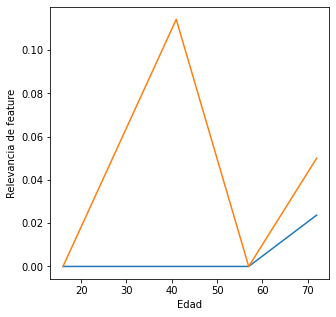

In [ ]:
plt.rcParams["figure.figsize"] = (5,5)
mas =[]
fem = []
grupos = [16,41,57,72] # Centro de intervalos de edades
for j in range(0,len(xGrupoEtario)):
  fem.append(sumaImportancia[j][5])
  mas.append(sumaImportancia[j][6])
plt.plot(grupos, fem, label='Mujeres')
plt.plot(grupos, mas, label='Hombres')
plt.xlabel('Edad')
plt.ylabel('Relevancia de feature')

Podriamos pensar que el genero tiene su pico de relevancia en mujeres con las adultas jovenes entre 33 y 50, pero es una feature que si bien aumenta en ese grupo etario sigue siendo muy baja su importancia a nivel relativo con las features ya conocidas de manera relevante.

#En conclusiones el genero si varia en importancia pero de manera muy poco significativa. 